In [1]:
import re
import operator

import pandas as pd
import seaborn as sns
import numpy as np
import nltk

from collections import defaultdict
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from matplotlib import pyplot as plt, rcParams

import warnings

warnings.filterwarnings('ignore')
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /home/duma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%load_ext rpy2.ipython

In [3]:
df = pd.read_csv('music.csv')

In [4]:
# Get familiar with data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
artist.hotttnesss,10000.0,0.385552,0.143647,0.00000,0.325266,0.380742,0.453858,1.082503e+00
artist_mbtags_count,10000.0,0.524686,0.884095,0.00000,0.000000,0.000000,1.000000,9.000000e+00
bars_confidence,10000.0,0.239595,0.288259,0.00000,0.035000,0.120000,0.351000,8.855240e+00
bars_start,10000.0,1.065246,1.723468,0.00000,0.441590,0.785460,1.224075,5.974354e+01
beats_confidence,10000.0,0.613963,0.322441,0.00000,0.409750,0.686000,0.882000,1.000000e+00
beats_start,10000.0,0.428497,0.806217,-60.00000,0.194655,0.332585,0.500753,1.224583e+01
duration,10000.0,240.622038,246.084090,1.04444,176.032200,223.059140,276.375060,2.205000e+04
end_of_fade_in,10000.0,0.756708,1.858958,0.00000,0.000000,0.199000,0.421000,4.311900e+01
familiarity,9996.0,0.565456,0.160161,0.00000,0.467611,0.563666,0.668020,1.000000e+00
key,10000.0,5.366580,9.671788,0.00000,2.000000,5.000000,8.000000,9.048028e+02


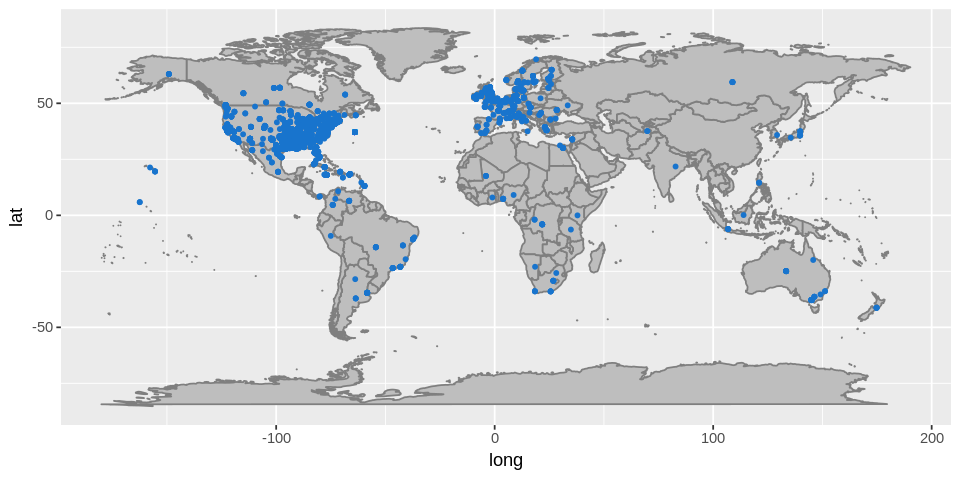

In [6]:
%%R
library('maps')
library('ggplot2')
library(repr)

options(repr.plot.width = 8, repr.plot.height = 4)

df <- read.csv('music.csv')

ggplot() +
  borders("world", colour="gray50", fill="gray") +
  geom_point(aes(x=df$longitude, y=df$latitude), color="dodgerblue3", size=1)

#### There are many songs fom USA and Great Britan. So we should expect results biased to these cultures.

In [6]:
len(df.terms.unique())

459

### There are 459 music terms, let's reduce them to the main genres

In [7]:
def reduce_music_genre(genre):
    genre = str(genre)
    for g in ('rock','blue-eyed soul', 'post-hardcore', 'new wave', ):
        if g in genre:
            return 'rock'
    if 'metal' in genre or 'hardcore' in genre:
        return 'metal'
    for g in ('hip hop', 'rap', 'hop', 'r&b'):
        if g in genre:
            return 'hip hop'
    for g in ('electric', 'tech', 'breakbeat', 'breakcore','chill-out','indietronica','electric blues'):
        if g in genre:
            return 'electro'
    for g in ('bachata', 'salsa', 'disco', 'tango',):
        if g in genre:
            return 'dance'
    for g in ('punk', 'jaz', 'pop', 'country', 'house', 'blues', 
              'folk', 'dance', 'rock', 'soul', 'classical', 'soundtrack',
             'reggae', ):
        if g in genre:
            return g
    return 'other'

df['genre'] = df.terms.apply(reduce_music_genre)

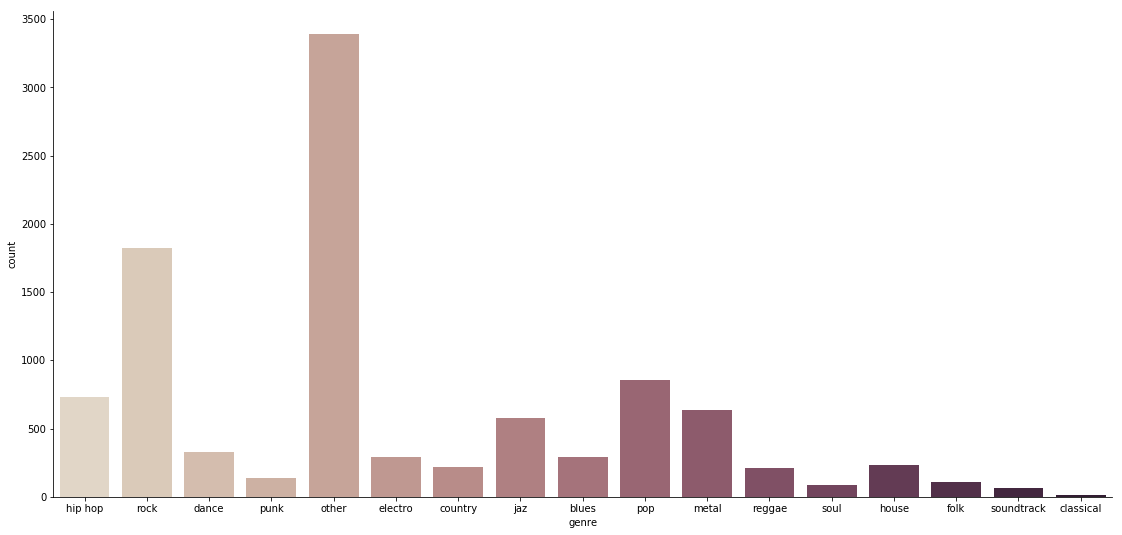

In [8]:
g = sns.catplot(x="genre", kind="count", palette="ch:.25", data=df)
g.fig.set_size_inches(18,8)

### Most common music genres in presented in sample are rock, pop, hip hop and metal

### Let's explore song tempo with respect to genre

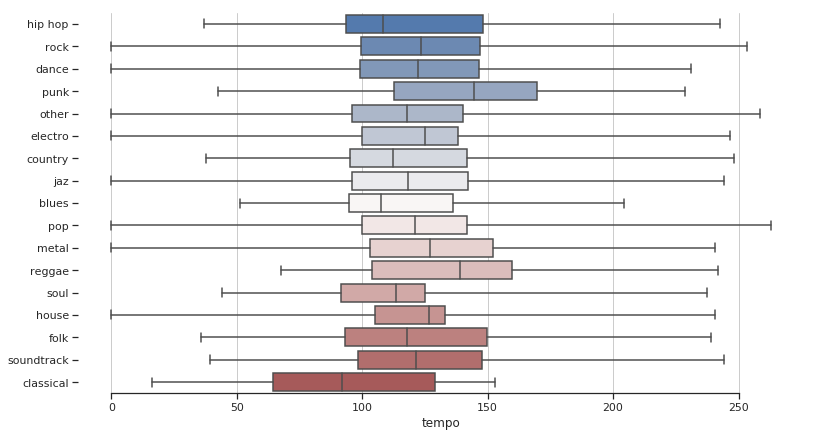

In [9]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(13, 7))

sns.boxplot(x="tempo", y="genre", data=df, whis="range", palette="vlag")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

### We can notice that there are many outliers which can cause wrong assumptions
### Let's cut them off

In [10]:
def trim_percentile(df, column, quantile=0.05):
    return df[
        (df[column] > df[column].quantile(quantile)) &  (df[column] < df[column].quantile(1 - quantile))
    ]

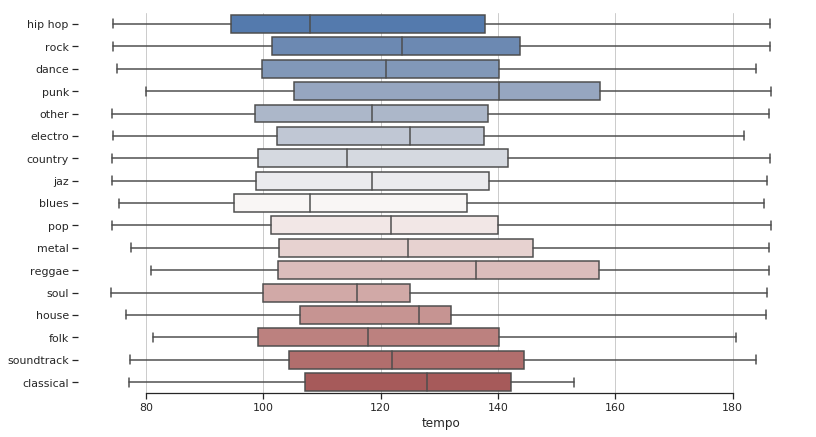

In [11]:
df_trimmed = pd.DataFrame(columns=df.columns)
for genre in df.genre.unique():
    songs = df[df.genre==genre]
    trimmed = trim_percentile(df, 'tempo')
    df_trimmed = df_trimmed.append(trimmed)
    
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(13, 7))

sns.boxplot(x="tempo", y="genre", data=df_trimmed, whis="range", palette="vlag")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

#### Punk and reggae are faster than average.
#### Hip hop, blues soul and country are slower (has lower tempo).
#### It's strange that classical music is relatively fast in our sample

### Take a look at songs start tatums 

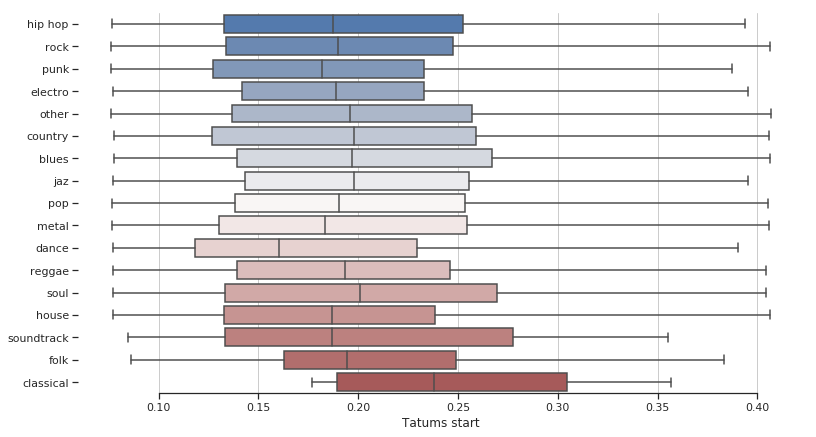

In [12]:
df_tatums_trimmed = trim_percentile(df, 'tatums_start', 0.15)
sns.set(style="ticks")

f, ax = plt.subplots(figsize=(13, 7))

sns.boxplot(x="tatums_start", y="genre", data=df_tatums_trimmed, whis="range", palette="vlag")

ax.xaxis.grid(True)
ax.set(xlabel="Tatums start", ylabel="")
sns.despine(trim=True, left=True)

#### Classical music and soundtracks has the biggest time interval between successive notes in a rhythmic phrase 
#### Dance music, on the contrary, has the smallest time intervals. This means that dance music keeps people in the rhythm  from the beginning of the song.

### Now  let's calculate fading out duration for each genre
### Fading out duration is total song duration subtracted with fade out time

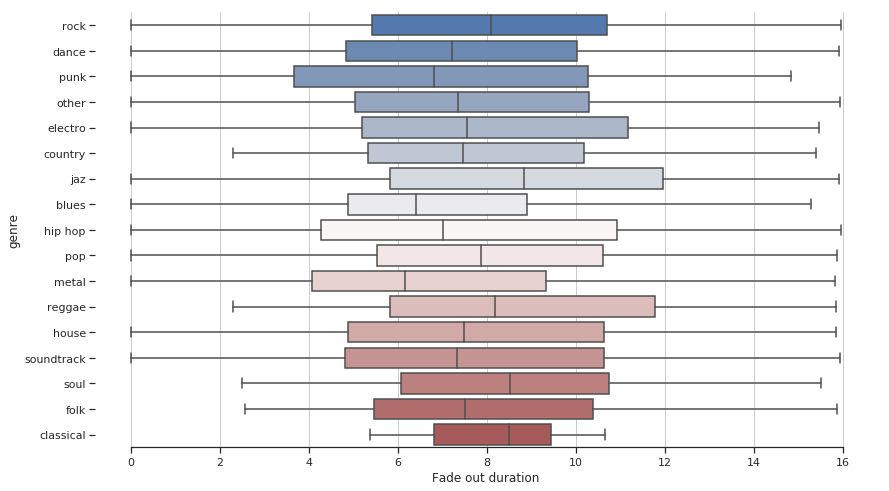

In [13]:
df['fade_out_duration'] = df.duration-df.start_of_fade_out
df_fade_out_duration_trimmed = trim_percentile(df, 'fade_out_duration', 0.1)
    
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(14, 8))

sns.boxplot(x="fade_out_duration", y="genre", data=df_fade_out_duration_trimmed, whis="range", palette="vlag")

ax.xaxis.grid(True)
ax.set(xlabel="Fade out duration")
sns.despine(trim=True, left=True)

#### We can see that jaz, soul, reggie and classical music has longer fade out duration 

### Let's observe music loudness with respect to genre

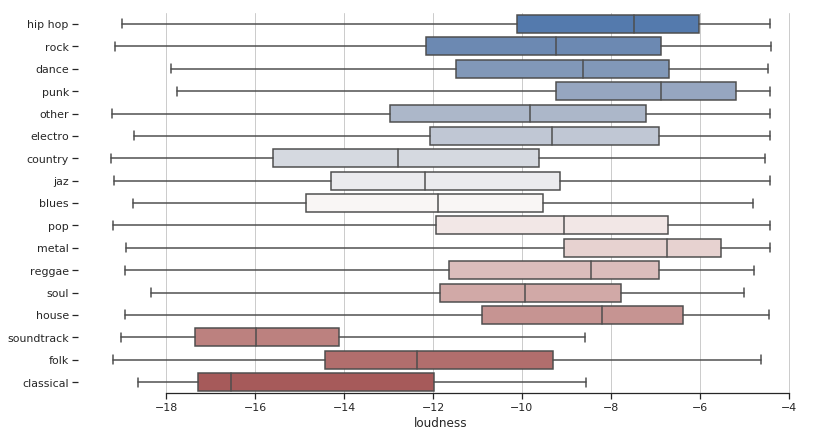

In [14]:
df_loudness_trimmed = trim_percentile(df, 'loudness', 0.07)
sns.set(style="ticks")

f, ax = plt.subplots(figsize=(13, 7))

sns.boxplot(x="loudness", y="genre", data=df_loudness_trimmed, whis="range", palette="vlag")

ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

#### Soundtracks, as expected, have mean loudness  -16 LUFS, as they are played on TVs, and 16 LUFS is the requirement for  TV broadcasting.
#### Also the most quiet music genres (in terms of LUFS) are classical and folk.
#### And the most loud music is, as expected, metal.
#### Surprisingly, but hip hop, punk and house seems to be more loud than rock.

### Some say, that music becomes louder (in terms of LUFS) with time. Let's check this assumption.

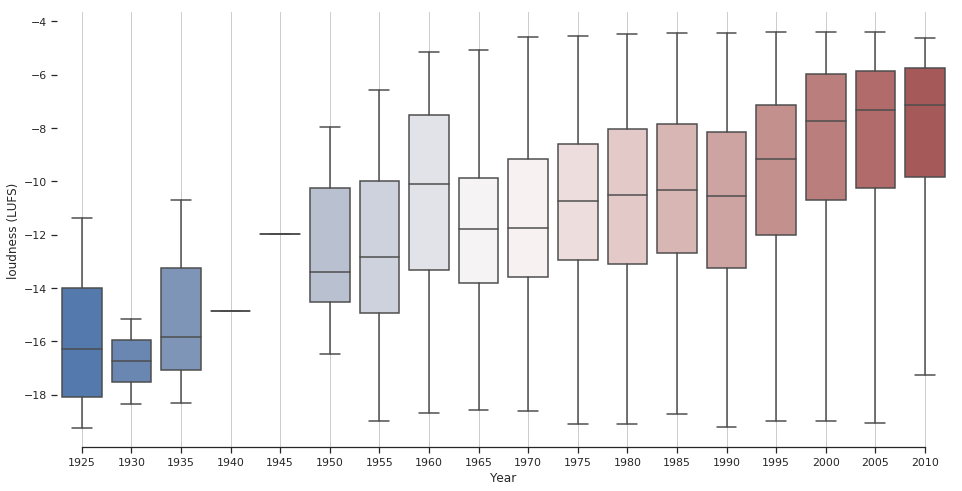

In [15]:
df_year = df_loudness_trimmed[df_loudness_trimmed.year>0]
df_year.year = df_year.year.apply(lambda year: year - year%5) 

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x="year", y="loudness", data=df_year,
            whis="range", palette="vlag")

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="loudness (LUFS)", xlabel='Year')
sns.despine(trim=True, left=True)

#### Assumption is confirmed. We can easily see the trend that music becomes louder (in lufs) with time
#### Also we can see, that rock&roll era changed trend in nineteen-sixties

### Now let's explore word frequency in song titles

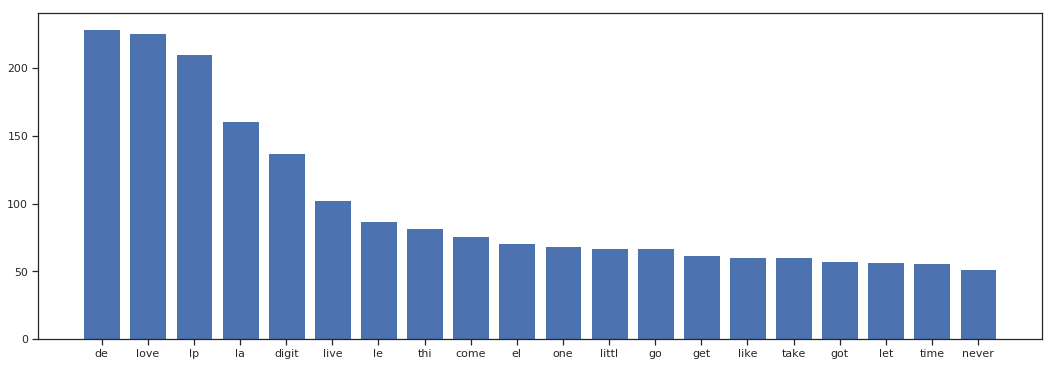

In [16]:
porter_stemmer = PorterStemmer()
regex = r'(\w*) '
d = defaultdict(int)
stop_words = set(stopwords.words('english')).union(['album'])


for title in df.title:
    words = re.findall(regex, str(title).lower())
    stemmed = (porter_stemmer.stem(word) for word in words)
    for word in stemmed:
        if word and word not in stop_words:
            d[word] += 1
            
words_frequency = sorted(d.items(), key=operator.itemgetter(1), reverse=True)[0:20]
f, ax = plt.subplots(figsize=(18, 6))

ax.bar(x=[wf[0] for wf in words_frequency] , height=[wf[1] for wf in words_frequency]);

#### We can observe here that love is one of the main topics in music 